# XGBoost
Training auf IDS18 80%  
Validierung auf IDS18 10%   
Test auf IDS18 10%

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import joblib

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnisse der Datensätze
parquet_verzeichnis_ids17 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet'
parquet_verzeichnis_ids18 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet'

### Laden von IDS18

In [3]:
# ids18 Datensatz einlesen für Training 80%, Validierung 10% und Test 10%
ids18 = pd.read_parquet(os.path.join(parquet_verzeichnis_ids18 + '_prep_0'))
print("Class distribution\n{}".format(ids18.Label.value_counts()))

Class distribution
Label
BENIGN                                          5935340
DoS Hulk                                        1803160
DDoS-LOIC-HTTP                                   289328
Botnet Ares                                      142921
SSH-BruteForce                                    94197
Infiltration - NMAP Portscan                      89374
DoS GoldenEye                                     22560
DoS Slowloris                                      8490
Web Attack - Brute Force                            131
Web Attack - XSS                                    113
Web Attack - SQL                                     39
DDoS-LOIC-UDP - Attempted                             0
DoS Hulk - Attempted                                  0
DoS Slowloris - Attempted                             0
DoS GoldenEye - Attempted                             0
Web Attack - XSS - Attempted                          0
Web Attack - Brute Force - Attempted                  0
Web Attack - SQL - Atte

In [4]:
print(ids18.shape)
print(ids18.columns)

(8385653, 84)
Index(['Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Bwd packets', 'Total Length of Fwd Packet',
       'Total Length of Bwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Vari

### Trennen von Features und Labels

In [5]:
X = ids18.iloc[:, :-1]  # Alle Spalten außer der letzten
print(f"Form von X: {X.shape}")
y = ids18.iloc[:, -1]   # Die letzte Spalte
print(f"Form von y: {y.shape}")

Form von X: (8385653, 83)
Form von y: (8385653,)


### Label Encoding für y

In [6]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Einzigartige Labels: {label_encoder.classes_}")
print(f"Kodierte Labels: {np.unique(y_encoded)}")

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce'
 'Web Attack - Brute Force' 'Web Attack - SQL' 'Web Attack - XSS']
Kodierte Labels: [ 0  1  2  3  4  5  6  7  8  9 10]


### Skallierung von X

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Form von X: {X.shape}")
print(f"Form von X_scaled: {X_scaled.shape}")

Form von X: (8385653, 83)
Form von X_scaled: (8385653, 83)


### Aufteilen der Daten in Trainings-, Validierungs- und Testdatensätze

In [8]:
# Aufteilen in Trainings- und temporären Datensatz
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)

# Aufteilen des temporären Datensatzes in Validierung und Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print(f"Form von X_train: {X_train.shape}")
print(f"Form von X_val: {X_val.shape}")
print(f"Form von X_test: {X_test.shape}")

Form von X_train: (6708522, 83)
Form von X_val: (838565, 83)
Form von X_test: (838566, 83)


### Überprüfen der Klassenverteilung

In [9]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_train, "Trainingsdatensatz")
print_class_distribution(y_val, "Validierungsdatensatz")
print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Trainingsdatensatz:
  Klasse 0: 4748272 Beispiele (70.78%)
  Klasse 1: 114337 Beispiele (1.70%)
  Klasse 2: 231462 Beispiele (3.45%)
  Klasse 3: 18048 Beispiele (0.27%)
  Klasse 4: 1442528 Beispiele (21.50%)
  Klasse 5: 6792 Beispiele (0.10%)
  Klasse 6: 71499 Beispiele (1.07%)
  Klasse 7: 75358 Beispiele (1.12%)
  Klasse 8: 105 Beispiele (0.00%)
  Klasse 9: 31 Beispiele (0.00%)
  Klasse 10: 90 Beispiele (0.00%)

Klassenverteilung in Validierungsdatensatz:
  Klasse 0: 593534 Beispiele (70.78%)
  Klasse 1: 14292 Beispiele (1.70%)
  Klasse 2: 28933 Beispiele (3.45%)
  Klasse 3: 2256 Beispiele (0.27%)
  Klasse 4: 180316 Beispiele (21.50%)
  Klasse 5: 849 Beispiele (0.10%)
  Klasse 6: 8937 Beispiele (1.07%)
  Klasse 7: 9419 Beispiele (1.12%)
  Klasse 8: 13 Beispiele (0.00%)
  Klasse 9: 4 Beispiele (0.00%)
  Klasse 10: 12 Beispiele (0.00%)

Klassenverteilung in Testdatensatz:
  Klasse 0: 593534 Beispiele (70.78%)
  Klasse 1: 14292 Beispiele (1.70%)
  Klasse 2: 28933 Bei

### Hyperparameter-Tuning mit dem Validierungsdatensatz

In [ ]:
#Beste Parameter aus 121_XGBoost 2024-11-05 09:06:10 - INFO - Beste Hyperparameter: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

# Folgende Paramter bei 170GB RAM Load auf 28 Kernen abgebrochen
# param_grid = {
#     'n_estimators': [100, 200],      # Anzahl der Bäume im Modell
#     'max_depth': [3, 6, 10],         # Maximale Tiefe der Bäume
#     'learning_rate': [0.01, 0.1, 0.2],  # Lernrate für den Boosting-Prozess
#     'subsample': [0.8, 1.0]          # Prozentsatz der verwendeten Datenpunkte pro Baum
# }

# Test mit Parametern aus 121_XGBoost = ERKENNT GLATTE 0 ANGRIFFE
param_grid = {
    'n_estimators': [200],      # Anzahl der Bäume im Modell
    'max_depth': [3],         # Maximale Tiefe der Bäume
    'learning_rate': [0.2],  # Lernrate für den Boosting-Prozess
    'subsample': [0.8]          # Prozentsatz der verwendeten Datenpunkte pro Baum
}


grid_search = GridSearchCV(XGBClassifier( 
    eval_metric='mlogloss',
    random_state=42), 
    param_grid, 
    cv=2, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=10)


grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8[CV 2/2; 1/1] START learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8



/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:20:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:20:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/2; 1/1] END learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8;, score=1.000 total time= 8.3min
[CV 1/2; 1/1] END learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8;, score=1.000 total time=10.0min


/home/michi/BA/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:29:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2], 'max_depth': [3],
                         'n_estimators': [200], 'subsample': [0.8]},
             scoring='accuracy', verbose=10)

 ### Bestes Modell auswählen

In [11]:
best_model = grid_search.best_estimator_
logging.info(f"Beste Hyperparameter: {grid_search.best_params_}")

2024-11-05 10:33:45 - INFO - Beste Hyperparameter: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


### Evaluierung auf dem Validierungsdatensatz

In [12]:
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

logging.info(f"Validierungs-Accuracy: {val_accuracy * 100:.2f}%")
logging.info("\nValidierungs Classification Report:\n" + val_report)

2024-11-05 10:33:46 - INFO - Validierungs-Accuracy: 100.00%
2024-11-05 10:33:46 - INFO - 
Validierungs Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    593534
           1       1.00      1.00      1.00     14292
           2       1.00      1.00      1.00     28933
           3       1.00      1.00      1.00      2256
           4       1.00      1.00      1.00    180316
           5       1.00      1.00      1.00       849
           6       1.00      1.00      1.00      8937
           7       1.00      1.00      1.00      9419
           8       0.93      1.00      0.96        13
           9       1.00      1.00      1.00         4
          10       1.00      0.83      0.91        12

    accuracy                           1.00    838565
   macro avg       0.99      0.98      0.99    838565
weighted avg       1.00      1.00      1.00    838565



### Evaluierung des Modells auf dem Testdatensatz

In [13]:
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
logging.info(f"Test-Accuracy: {test_accuracy * 100:.2f}%")
logging.info("\nTest Classification Report:\n" + test_report)

2024-11-05 10:33:47 - INFO - Test-Accuracy: 100.00%
2024-11-05 10:33:47 - INFO - 
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    593534
           1       1.00      1.00      1.00     14292
           2       1.00      1.00      1.00     28933
           3       1.00      1.00      1.00      2256
           4       1.00      1.00      1.00    180316
           5       1.00      1.00      1.00       849
           6       1.00      1.00      1.00      8938
           7       1.00      1.00      1.00      9420
           8       1.00      1.00      1.00        13
           9       1.00      0.25      0.40         4
          10       1.00      1.00      1.00        11

    accuracy                           1.00    838566
   macro avg       1.00      0.93      0.95    838566
weighted avg       1.00      1.00      1.00    838566



### Klassifikationsbericht und eine Konfusionsmatrix

In [14]:
# Klassifikationsbericht
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_test_pred)
print("Konfusionsmatrix:")
print(cm)

                              precision    recall  f1-score   support

                      BENIGN       1.00      1.00      1.00    593534
                 Botnet Ares       1.00      1.00      1.00     14292
              DDoS-LOIC-HTTP       1.00      1.00      1.00     28933
               DoS GoldenEye       1.00      1.00      1.00      2256
                    DoS Hulk       1.00      1.00      1.00    180316
               DoS Slowloris       1.00      1.00      1.00       849
Infiltration - NMAP Portscan       1.00      1.00      1.00      8938
              SSH-BruteForce       1.00      1.00      1.00      9420
    Web Attack - Brute Force       1.00      1.00      1.00        13
            Web Attack - SQL       1.00      0.25      0.40         4
            Web Attack - XSS       1.00      1.00      1.00        11

                    accuracy                           1.00    838566
                   macro avg       1.00      0.93      0.95    838566
                we

Visualisierung der Konfusionsmatrix

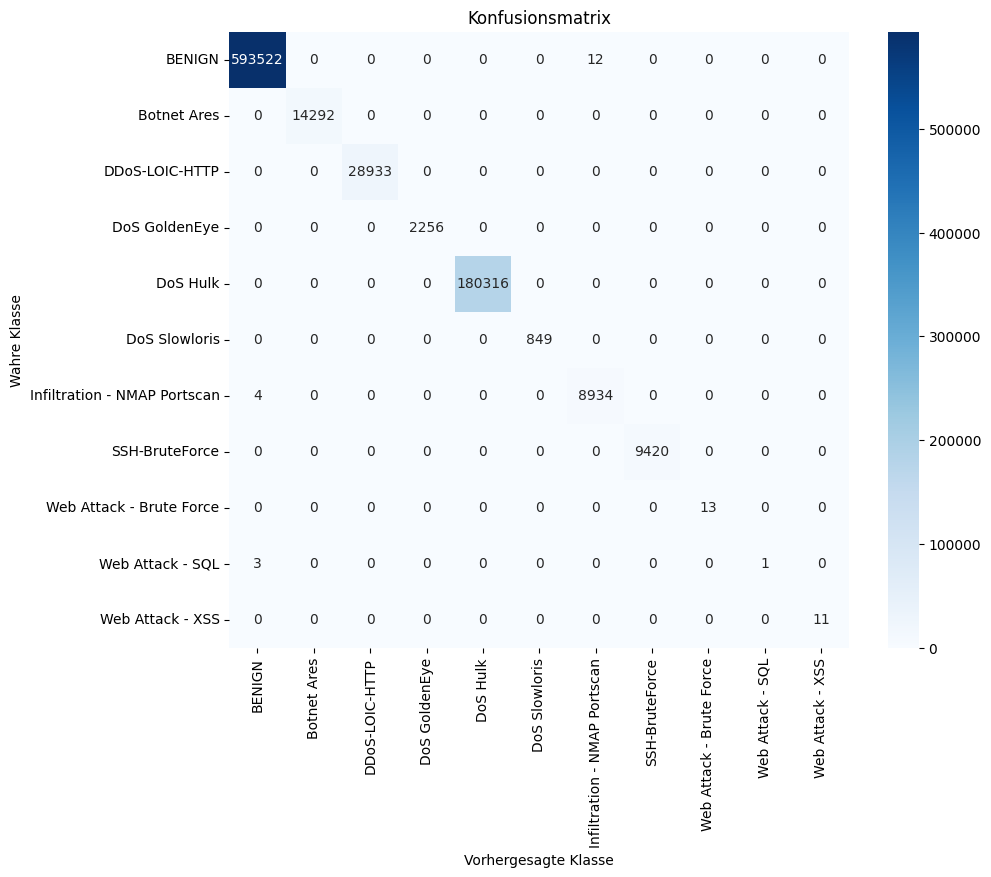

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()


### Speichern des Modells und der Vorverarbeitungsschritte

In [16]:
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(best_model, 'xgboost_model.pkl')

['xgboost_model.pkl']